In [ ]:
#BBBY  ticker  Bed Bath & Beyond

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

from yahoo_fin.stock_info import get_data

In [ ]:
#interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

In [41]:
api_df= get_data("bbby", start_date="12/04/2010", end_date="07/04/2022", index_as_date = False, interval="1d")
api_df

,date,open,high,low,close,adjclose,volume,ticker
0,2010-12-06,45.790001,45.950001,45.610001,45.790001,39.923748,1089600,BBBY
1,2010-12-07,46.209999,46.750000,45.790001,45.849998,39.976063,1894000,BBBY
2,2010-12-08,46.130001,46.459999,45.820000,46.250000,40.324810,1927700,BBBY
3,2010-12-09,46.400002,46.650002,46.200001,46.520000,40.560226,1358100,BBBY
4,2010-12-10,46.669998,46.860001,46.150002,46.759998,40.769478,1724200,BBBY
...,...,...,...,...,...,...,...,...
2908,2022-06-27,6.770000,7.020000,6.410000,6.750000,6.750000,7456600,BBBY
2909,2022-06-28,6.700000,6.870000,6.350000,6.530000,6.530000,8411000,BBBY
2910,2022-06-29,5.460000,5.460000,4.910000,4.990000,4.990000,35110100,BBBY
2911,2022-06-30,4.850000,5.330000,4.730000,4.970000,4.970000,19239200,BBBY


In [42]:
#print the summary 
print(api_df.describe())

              open         high          low        close     adjclose  \
count  2913.000000  2913.000000  2913.000000  2913.000000  2913.000000   
mean     41.241682    41.802921    40.705836    41.232358    36.627617   
std      22.684393    22.769880    22.612588    22.703399    19.211707   
min       3.550000     4.050000     3.430000     3.560000     3.560000   
25%      18.790001    19.240000    18.389999    18.770000    17.479641   
50%      43.290001    44.040001    42.730000    43.389999    37.900959   
75%      61.750000    62.310001    61.180000    61.720001    53.812916   
max      80.269997    80.820000    79.860001    80.480003    70.169540   

             volume  
count  2.913000e+03  
mean   4.644686e+06  
std    6.897087e+06  
min    4.807000e+05  
25%    1.976700e+06  
50%    2.894600e+06  
75%    4.810200e+06  
max    1.098713e+08  


In [43]:
#prep the data 
api_df.set_index(pd.DatetimeIndex(api_df['date']), inplace=True)

In [44]:
#Keep the close for 2014-19
api_df = api_df[['close']]
api_df

,close
date,
2010-12-06,45.790001
2010-12-07,45.849998
2010-12-08,46.250000
2010-12-09,46.520000
2010-12-10,46.759998
...,...
2022-06-27,6.750000
2022-06-28,6.530000
2022-06-29,4.990000


In [45]:
print (api_df.index.max())

2022-07-01 00:00:00


In [46]:
data = api_df.filter(['close'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len =math.ceil(len(dataset) *.7)
train_data =scaled_data[0:training_data_len , : ]


X_train_data = []
y_train_data = []

for i in range(1500,len(train_data)):
    X_train_data=list(X_train_data)
    y_train_data=list(y_train_data)
    X_train_data.append(train_data[i-1500:i,0])
    y_train_data.append(train_data[i,0])
    
    X_train_data1, y_train_data1 = np.array(X_train_data), np.array(y_train_data)
    
    X_train_data2 = np.reshape(X_train_data1,(X_train_data1.shape[0],X_train_data1.shape[1],1))

   
    
#1500 = number of days you can change it accordingly. 

# There will be a total of 60 values, 1st column will contain an index of 0-59
# The second will have an index of 1-60 ++_
# the y_train has the 60 st value on c1 and c2 will have 61++

In [47]:
#Build the LSTM MODEL 

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_data2.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))

model.add(Dense(units=1))

In [48]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_data2, y_train_data1, batch_size=1, epochs=1)

540/540 [==============================] - 348s 631ms/step - loss: 0.0013


In [49]:
test_data = scaled_data[training_data_len -1500: , : ]

X_test = []

y_test = dataset[training_data_len : , : ]

for i in range(1500,len(test_data)):
    
    X_test.append(test_data[i-1500:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)

28/28 [==============================] - 14s 422ms/step


In [50]:
# Error calculation where RMSE = root mean squared error 

rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

In [51]:
print(rmse)

2.532647731132066


C:\Users\rctay\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


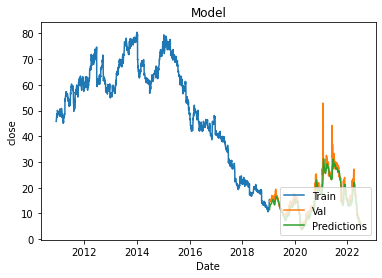

In [52]:
#Predict and visualize 

train = api_df[:training_data_len]

valid = api_df[training_data_len:]

valid['Predictions'] = predictions

plt.title('Model')

plt.xlabel('Date')

plt.ylabel('close')

plt.plot(train['close'])

plt.plot(valid[['close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

<AxesSubplot:xlabel='date'>

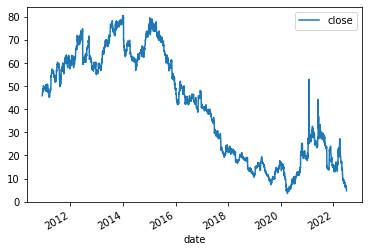

In [53]:
api_df.plot()